In [50]:
import logging
from vresutils import plot as vplot

import pandas as pd
import geopandas as gpd
import numpy as np
import pypsa

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Circle, Ellipse
from matplotlib.legend_handler import HandlerPatch
to_rgba = mpl.colors.colorConverter.to_rgba
logger = logging.getLogger(__name__)


%run ../scripts/_helpers.py
#from _helpers import (load_network_for_plots, aggregate_p, aggregate_costs, configure_logging)

In [51]:
def make_handler_map_to_scale_circles_as_in(ax, dont_resize_actively=False):
    fig = ax.get_figure()

    def axes2pt():
        return np.diff(ax.transData.transform([(0, 0), (1, 1)]), axis=0)[0] * (72.0 / fig.dpi)

    ellipses = []
    if not dont_resize_actively:

        def update_width_height(event):
            dist = axes2pt()
            for e, radius in ellipses:
                e.width, e.height = 2.0 * radius * dist

        fig.canvas.mpl_connect("resize_event", update_width_height)
        ax.callbacks.connect("xlim_changed", update_width_height)
        ax.callbacks.connect("ylim_changed", update_width_height)

    def legend_circle_handler(
        legend, orig_handle, xdescent, ydescent, width, height, fontsize
    ):
        w, h = 2.0 * orig_handle.get_radius() * axes2pt()
        e = Ellipse(
            xy=(0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent),
            width=w,
            height=w,
        )
        ellipses.append((e, orig_handle.get_radius()))
        return e

    return {Circle: HandlerPatch(patch_func=legend_circle_handler)}


def make_legend_circles_for(sizes, scale=1.0, **kw):
    return [Circle((0, 0), radius=(s / scale) ** 0.5, **kw) for s in sizes]

def set_plot_style():
    plt.style.use(
        [
            "classic",
            "seaborn-white",
            {
                "axes.grid": False,
                "grid.linestyle": "--",
                "grid.color": "0.6",
                "hatch.color": "white",
                "patch.linewidth": 0.5,
                "font.size": 12,
                "legend.fontsize": "medium",
                "lines.linewidth": 1.5,
                "pdf.fonttype": 42,
            },
        ]
    )

def plot_map(n, opts, ax=None, attribute='p_nom'):
    if ax is None:
        ax = plt.gca()
## DATA
    line_colors = {'cur': "purple",
               'exp': mpl.colors.rgb2hex(to_rgba("red", 0.7), True)}
    tech_colors = opts['tech_colors']

    if attribute == 'p_nom':
        # bus_sizes = n.generators_t.p.sum().loc[n.generators.carrier == "load"].groupby(n.generators.bus).sum()
        bus_sizes = pd.concat((n.generators[n.get_active_assets('Generator',2040)].query('carrier != "load_shedding"').groupby(['bus', 'carrier']).p_nom_opt.sum(),
                              n.storage_units.groupby(['bus', 'carrier']).p_nom_opt.sum()))
        line_widths_exp = n.lines.s_nom_opt
        line_widths_cur = n.lines.s_nom_min
        link_widths_exp = n.links.p_nom_opt
        link_widths_cur = n.links.p_nom_min
    else:
        raise 'plotting of {} has not been implemented yet'.format(attribute)


    line_colors_with_alpha = (line_widths_cur / n.lines.s_nom > 1e-3).map(
        {True: line_colors["cur"], False: to_rgba(line_colors["cur"], 0.0)}
    )
    link_colors_with_alpha = (link_widths_cur / n.links.p_nom > 1e-3).map(
        {True: line_colors["cur"], False: to_rgba(line_colors["cur"], 0.0)}
    )

    ## FORMAT
    linewidth_factor = opts['map'][snakemake.wildcards.attr]['linewidth_factor']
    bus_size_factor  = opts['map'][snakemake.wildcards.attr]['bus_size_factor']
    supply_regions.plot(ax=ax, facecolor = (0, 0, 0, 0), edgecolor='darkgray', linewidth=0.5)
    resarea.plot(ax=ax, facecolor='gray', alpha=0.2, linewidth=0.5)
    #vplot.shapes(supply_regions.geometry, facecolors='k', outline='k', ax=ax, rasterized=True)
    #vplot.shapes(resarea.geometry, facecolors='gray', alpha=0.2, ax=ax, rasterized=True)
    ## PLOT
    flow = pd.Series(5, index=n.branches().index)

    n.plot(line_widths=line_widths_exp/linewidth_factor,
        line_colors=line_colors["exp"],
        link_colors=line_colors["exp"],
        bus_sizes=bus_sizes/bus_size_factor,
        bus_colors=tech_colors,
        boundaries=map_boundaries,
        color_geomap=True,
        geomap=True,
        #flow=flow,
        ax=ax)
    n.plot(line_widths=line_widths_cur/linewidth_factor,
        line_colors=line_colors_with_alpha,
        link_colors=link_colors_with_alpha,
        bus_sizes=0,
        bus_colors=tech_colors,
        boundaries=map_boundaries,
        color_geomap=True,
        geomap=True,
        #flow=flow,
        ax=ax)
    ax.set_aspect('equal')
    ax.axis('off')

    # Rasterize basemap
    for c in ax.collections[:2]: c.set_rasterized(True)

    # LEGEND
    handles = []
    labels = []

    for s in (10, 5):
        handles.append(plt.Line2D([0],[0],color=line_colors['exp'],
                                linewidth=s*1e3/linewidth_factor))
        labels.append("{} GW".format(s))
    l1 = l1_1 = ax.legend(handles, labels,
                loc="upper left", bbox_to_anchor=(0.6,1.3),#(0.24, 1.01),
                frameon=False,
                labelspacing=0.8, handletextpad=1.5,
                title='Transmission Exist./Exp.')
    ax.add_artist(l1_1)

    handles = []
    labels = []
    for s in (10, 5):
        handles.append(plt.Line2D([0],[0],color=line_colors['cur'],
                                linewidth=s*1e3/linewidth_factor))
        labels.append("/")
    l1_2 = ax.legend(handles, labels,
                loc="upper left", bbox_to_anchor=(0.62,1.3),#(0.26, 1.01),
                frameon=False,
                labelspacing=0.8, handletextpad=0.5,
                title=' ')
    ax.add_artist(l1_2)

    handles = make_legend_circles_for([10e3, 5e3, 1e3], scale=bus_size_factor, facecolor="w")
    labels = ["{} GW".format(s) for s in (10, 5, 3)]
    l2 = ax.legend(handles, labels,
                loc="upper left", bbox_to_anchor=(0.35,1.3),#(0.01, 1.01),
                frameon=False, labelspacing=1.0,
                title='Generation',
                handler_map=make_handler_map_to_scale_circles_as_in(ax))
    ax.add_artist(l2)

    techs =  (bus_sizes.index.levels[1]).intersection(pd.Index(opts['vre_techs'] + opts['conv_techs'] + opts['storage_techs']))
    handles = []
    labels = []
    for t in techs:
        handles.append(plt.Line2D([0], [0], color=tech_colors[t], marker='o', markersize=8, linewidth=0))
        labels.append(opts['nice_names'].get(t, t))
    l3 = ax.legend(handles, labels, loc="lower left",  bbox_to_anchor=(0.6, -0.3), # bbox_to_anchor=(0.72, -0.05),
                handletextpad=0., columnspacing=0.5, ncol=2, title='Technology')
    return fig

def plot_total_energy_pie(n, opts, ax=None):
    if ax is None: ax = plt.gca()

    ax.set_title('Energy per technology', fontdict=dict(fontsize="medium"))

    e_primary = aggregate_p(n).drop('load', errors='ignore').loc[lambda s: s>0]

    patches, texts, autotexts = ax.pie(e_primary,
        startangle=90,
        labels = e_primary.rename(opts['nice_names']).index,
        autopct='%.0f%%',
        textprops=dict(),
        shadow=False,
        colors = [opts['tech_colors'][tech] for tech in e_primary.index])
    for t1, t2, i in zip(texts, autotexts, e_primary.index):
        if e_primary.at[i] < 0.04 * e_primary.sum():
            t1.remove()
            t2.remove()


def plot_total_cost_bar(n, opts, ax=None):
    if ax is None: ax = plt.gca()

    total_load = (n.snapshot_weightings.generators.loc[2040] * n.loads_t.p.loc[2040].sum(axis=1)).sum()
    tech_colors = opts['tech_colors']

    #def split_costs(n):
    #    costs = aggregate_costs(n).reset_index(level=0, drop=True)
    #    costs_ex = aggregate_costs(n, existing_only=True).reset_index(level=0, drop=True)
    #    return (
    #        costs['capital'].add(costs['marginal'], fill_value=0.),
    #        costs_ex['capital'], 
    #        costs['capital'] - costs_ex['capital'], 
    #        costs['marginal']
    #        )

    #costs, costs_cap_ex, costs_cap_new, costs_marg = split_costs(n)

    fixed_cost, variable_cost = aggregate_costs(n)

    costs = fixed_cost + variable_cost
    costs_marg = variable_cost

    costs_graph = pd.DataFrame(
        dict(a=costs[2040].drop("load_shedding", errors="ignore")),
        index=[
            'nuclear',
            'coal',
            'CCGT',
            'OCGT',
            'hydro+PHS',
            'biomass',
            'onwind',
            'CSP',
            'solar',
            'battery'
            "AC-AC",
            "AC line"
        ],
    ).dropna()
    bottom = np.array([0.0, 0.0])
    texts = []

    for i,ind in enumerate(costs_graph.index):
        data = np.asarray(costs_graph.loc[ind])/total_load
        ax.bar([0.5], data, bottom=bottom, color=tech_colors[ind],
               width=0.7, zorder=-1)
        bottom_sub = bottom
        bottom = bottom+data

        if ind in opts['conv_techs'] + ['AC line']:
            #for c in [costs_cap_ex, costs_marg]:
            for c in [costs[2040], costs_marg[2040]]:
                if ind in c:
                    data_sub = np.asarray([c.loc[ind]])/total_load
                    ax.bar([0.5], data_sub, linewidth=0,
                        bottom=bottom_sub, color=tech_colors[ind],
                        width=0.7, zorder=-1, alpha=0.8)
                    bottom_sub += data_sub

        if abs(data[-1]) < 5:
            continue

        text = ax.text(1.1,(bottom-0.5*data)[-1]-3,opts['nice_names'].get(ind,ind))
        texts.append(text)

    ax.set_ylabel("Average system cost [R/MWh]")
    ax.set_ylim([0, opts.get('costs_max', 80)])
    ax.set_xlim([0, 1])
    ax.set_xticklabels([])
    ax.grid(True, axis="y", color='k', linestyle='dotted')


In [52]:
snakemake = mock_snakemake(
    'plot_network', 
    **{
        'model_file':'grid-2040',
        'regions':'27-supply',
        'resarea':'redz',
        'll':'copt',
        'opts':'LC',
        'attr':'p_nom',
        'ext':'pdf'
    }
)  

INFO:pypsa.io:Imported network solved_grid-2040_27-supply_redz_lcopt_LC.nc has buses, carriers, generators, global_constraints, lines, loads, storage_units
/tmp/ipykernel_649257/146274088.py:24: UserWarning:

Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


/home/pklein/anaconda3/envs/pypsa-earth-updated/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning:

facecolor will have no effect as it has been defined as "never".

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing g

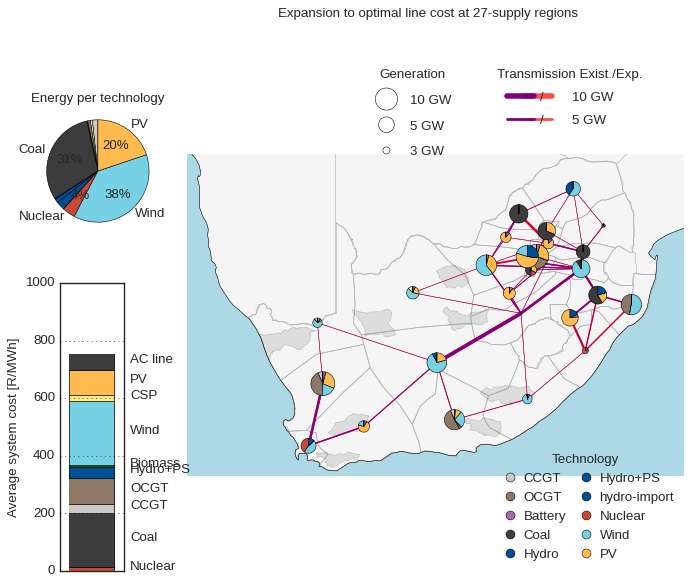

In [54]:
                                               
configure_logging(snakemake)

model_setup = (pd.read_excel(snakemake.input.model_file, 
                            sheet_name='model_setup',
                            index_col=[0])
                            .loc[snakemake.wildcards.model_file])

set_plot_style()

config, wildcards = snakemake.config, snakemake.wildcards

map_figsize = config["plotting"]['map']['figsize']
map_boundaries = config["plotting"]['map']['boundaries']
#config_years = [2050]

n = load_network_for_plots(
    snakemake.input.network, snakemake.input.model_file, config, model_setup.costs
)
scenario_opts = wildcards.opts.split('-')

supply_regions = gpd.read_file(
    snakemake.input.supply_regions,
    layer=snakemake.wildcards.regions,
).buffer(-0.005) #.to_crs(n.crs)
resarea = gpd.read_file(snakemake.input.resarea).to_crs(supply_regions.crs)

fig, ax = plt.subplots(figsize=map_figsize, subplot_kw={"projection": ccrs.PlateCarree()})

plot_map(n, config["plotting"], ax=ax, attribute=wildcards.attr)

fig.savefig(snakemake.output.only_map, dpi=150, bbox_inches='tight')

ax1 = fig.add_axes([-0.115, 0.625, 0.2, 0.2])
plot_total_energy_pie(n, config["plotting"], ax=ax1)

ax2 = fig.add_axes([-0.075, 0.1, 0.1, 0.45])
plot_total_cost_bar(n, config["plotting"], ax=ax2)

ll = wildcards.ll
ll_type = ll[0]
ll_factor = ll[1:]
lbl = dict(c='line cost', v='line volume')[ll_type]
amnt = '{ll} x today\'s'.format(ll=ll_factor) if ll_factor != 'opt' else 'optimal'
fig.suptitle('Expansion to {amount} {label} at {regions} regions'
            .format(amount=amnt, label=lbl, regions=wildcards.regions))
fig.savefig(snakemake.output.ext, transparent=True, bbox_inches='tight')
